# Data Loading and Processing Tutorial

This tutorial follows the steps delineated in the [data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html). We start loading the necessary libraries.

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform  # From sklearn-image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

The documentation of scikit-image can be found [here](http://scikit-image.org/docs/dev/user_guide). The images have been saved in `data/faces`. This folder contains a file called `create_landmark_dataset.py` and a `face_landmark.csv` file with the coordinates of the landmark points. There are 68 landmark points, and two coordinates for each point.

In [2]:
landmarks_frame = pd.read_csv('../data/faces/face_landmarks.csv')
print(landmarks_frame.shape)
landmarks_frame.head()

(69, 137)


,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


The first column contains the image names and the remaining 136 contain the coordinates of the landmarks, x coordinate first and y coordinate second. We could reshape it such that the first column contains the x coordinate and the second column contains the y coordinate.

In [3]:
img_name = landmarks_frame.iloc[:, 0].values
print(img_name[:3])
landmark = landmarks_frame.iloc[:, 1:].as_matrix()
landmarks = landmark.reshape(69, 68, 2)
print(landmarks.shape)

['0805personali01.jpg' '1084239450_e76e00b7e7.jpg' '10comm-decarlo.jpg']
(69, 68, 2)


The following code plots the landmarks over an image. Unlike the one in the original tutorial, this function takes an index and plots the image and the landmarks for the corresponding input.

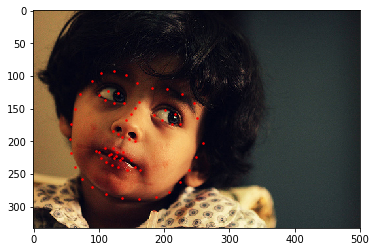

In [4]:
def show_landmarks(idx):
    """Show image with landmarks"""
    image = io.imread(os.path.join('../data/faces/', img_name[idx]))
    plt.imshow(image)
    landmark = landmarks[idx]
    plt.scatter(landmark[:, 0], landmark[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(24)
plt.show()

This approach, however, lacks flexibility. It is difficult, for example, to perform data augmentation. It is much better to create a flexible `Dataset` subclass that can accept arbitrary tranformations.
The class reads the landmarks file during the `__init__` phase, and takes the path to the images and an optional callable class of transformations `transform`. Note that `__getitem__` extracts the image name from the landmark and uses it to load the image. For each index, the image and the landmarks are extracted and used as values of a dictionary, which constitutes the return value.

In [5]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

We can instantiate this class just passing the path to the csv file and the folder containing the images.

In [6]:
face_dataset = FaceLandmarksDataset(csv_file='../data/faces/face_landmarks.csv',
                                    root_dir='../data/faces/')
len(face_dataset)
for i, sample in enumerate(face_dataset):
    print(sample['image'].shape)
    if i == 5:
        break

(324, 215, 3)
(500, 333, 3)
(250, 258, 3)
(434, 290, 3)
(828, 630, 3)
(402, 500, 3)


However it is much more useful if we also pass some transformations. These must operate not only on the images, but also on the landmarks. We consider a rescaling transformation and a random crop. Let's start with the rescaling transformation. Note that the `__init__` simply consisting in making sure that `output_size` is of the correct type, and storing it as an attribute. The `sample` dictionary is an argument of the `__call__` method.

In [7]:
class Rescale(object):
    """Rescale the image to a given size.
    
    Args:
        output_size (tuple or int). The desired output size. If an int this is assumed
        to be the new size of the shortest side, and the other side is rescaled such 
        to retain the aspect ratio. If a tuple, it is assumed to contain the new width and
        height.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2] # The third dimension is the number of channels
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = (h / w) * self.output_size, self.output_size
            else:
                new_h, new_w = self.output_size, (w / h) * self.output_size
        else:
            new_h, new_w = self.output_size
            
        # Why do we need to transform new_h, new_w into int?
        print('Before rounding: new_h = {0}, new_w = {1}'.format(new_h, new_w))
        new_h, new_w = int(round(new_h)), int(round(new_w))
        print('After rounding: new_h = {0}, new_w = {1}'.format(new_h, new_w))
        new_image = transform.resize(image, (new_h, new_w))
        
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        new_landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image': new_image, 'landmarks': new_landmarks}

Let's verify that this transformation actually works.

In [8]:
rescale = Rescale(244)
for i, sample in enumerate(face_dataset):
    transformed_sample = rescale(sample)
    print(transformed_sample['image'].shape)
    if i == 5:
        break

Before rounding: new_h = 367.7023255813953, new_w = 244
After rounding: new_h = 368, new_w = 244
(368, 244, 3)
Before rounding: new_h = 366.3663663663663, new_w = 244
After rounding: new_h = 366, new_w = 244
(366, 244, 3)
Before rounding: new_h = 244, new_w = 251.808
After rounding: new_h = 244, new_w = 252
(244, 252, 3)
Before rounding: new_h = 365.1586206896552, new_w = 244
After rounding: new_h = 365, new_w = 244
(365, 244, 3)
Before rounding: new_h = 320.6857142857143, new_w = 244
After rounding: new_h = 321, new_w = 244
(321, 244, 3)
Before rounding: new_h = 244, new_w = 303.4825870646766
After rounding: new_h = 244, new_w = 303
(244, 303, 3)


Let's see now the implementation of the random crop class. As before we pass the output size as a tuple or an int. In the latter case we apply a square crop. Then we select the new coordinates of the top-left corner of the image, and we crop accordingly only taking the portion of the image from this corner to the new height and width. Fixing the landmarks is also easy: since we are changing the coordinate origin, we just need to subtract the coordinates of `top` and `left` from the coordinates of all the landmarks.

In [9]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

The final transformation is to make sure that what is passed to the model is a PyTorch tensor. This must be true both for the image and for the landmarks (which, presumably, are the values we want to predict). Note that we don't need to create an `__init__` method for this class, as we don't need to store attributes.

In [10]:
class ToTensor(object):
    """Convert images and landmarks to tensors."""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        # We need to move the channels to the first axis
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

Finally assume that we want to combine multiple transformations at once. The `torchvision` library has a submodule called `transform`, which in turn has the `Compose` class that allows combining multiple transformations into one single callable class. `Compose` takes a list of transformations in input and returns an object of class `Compose`.

In [11]:
composed_transformations = transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()])
type(composed_transformations)

torchvision.transforms.transforms.Compose

The `Compose` class is indeed very simple, as it just applies the input transformations sequentially, as shown by the code below.

## Putting all the pieces together
We can now create an instance of the class `FaceLandmarksDataset` that takes, besides the paths to the landmark file and the image folder, a `Compose` object.

In [12]:
transformed_dataset = FaceLandmarksDataset(
    csv_file='../data/faces/face_landmarks.csv',
    root_dir='../data/faces/',
    transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))
len(transformed_dataset)

69

We have now a mechanism to produce image-landmark pairs, but this is still quite limited. If, for example, we want to produce batches with the possibility of shuffling the samples, we have to do it manually. The `torch.utils.data.DataLoader` class provides the following, valuable functionality:
1. Batch generation.
2. Data shuffling.
3. Parallel batch processing via the `multiprocessing` module.

In [13]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=2)

Following the tutorial, we create a batch visualization function.

In [14]:
def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = (sample_batched['image'], 
                                     sample_batched['landmarks'])
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    # Visualize the images
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose(1, 2, 0))
    
    # Visualize the grid
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

    plt.title('Batch from dataloader')

Before rounding: new_h = 383.23353293413174, new_w = 256
Before rounding: new_h = 256, new_w = 383.23353293413174
After rounding: new_h = 256, new_w = 383
After rounding: new_h = 383, new_w = 256
Before rounding: new_h = 256, new_w = 418.30065359477123
Before rounding: new_h = 367.81609195402297, new_w = 256
After rounding: new_h = 256, new_w = 418
After rounding: new_h = 368, new_w = 256
Before rounding: new_h = 256, new_w = 383.23353293413174
After rounding: new_h = 256, new_w = 383
Before rounding: new_h = 362.60623229461754, new_w = 256
After rounding: new_h = 363, new_w = 256
Before rounding: new_h = 256, new_w = 342.24598930481284
After rounding: new_h = 256, new_w = 342
Before rounding: new_h = 392.63803680981596, new_w = 256
After rounding: new_h = 393, new_w = 256
Before rounding: new_h = 383.23353293413174, new_w = 256
Before rounding: new_h = 256, new_w = 341.3333333333333
After rounding: new_h = 256, new_w = 341
After rounding: new_h = 383, new_w = 256
Before rounding: new_

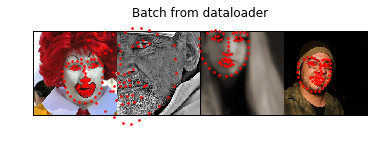

Before rounding: new_h = 389.301775147929, new_w = 256
After rounding: new_h = 389, new_w = 256
Before rounding: new_h = 282.3529411764706, new_w = 256
After rounding: new_h = 282, new_w = 256
Before rounding: new_h = 350.6849315068493, new_w = 256
After rounding: new_h = 351, new_w = 256


In [15]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break